# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [15]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open(r"anek.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [3]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [4]:
cut_text = cut_data(text)

In [5]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [6]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}

Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [7]:
def encode(sentence, vocab):
    return [vocab[ch] for ch in sentence]

def decode(tokens, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    return "".join([inv_vocab[token] for token in tokens])

In [8]:
# Проверьте, что энеодинг и декодинг работают

In [9]:
# Проверка функций
encoded = encode("Привет", char2int)
print(encoded)
decoded = decode(encoded, char2int)
print(decoded)

[155, 200, 107, 104, 63, 132]
Привет


Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве.

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [10]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    words_one_hot = torch.zeros((int_words.size(0), int_words.size(1), vocab_size))
    words_one_hot.scatter_(2, int_words.unsqueeze(2), 1)
    return words_one_hot


In [11]:
# Проверка
test_seq = torch.tensor([[2, 6, 4, 1], [0, 3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)
print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Проверьте ваш код.

In [12]:
test_seq = torch.tensor([[2, 6, 4, 1], [0, 3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)
print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [13]:
class Tokenizer:
    def __init__(self, text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(self.specials + list(unique_chars)))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

    @property
    def vocab_size(self):
        return len(self.int2char)

    def encode_symbol(self, el):
        return self.char2int.get(el, self.char2int['<pad>'])

    def decode_symbol(self, el):
        return self.int2char.get(el, '<pad>')

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return [self.encode_symbol(ch) for ch in chars]

    def decode(self, idx):
        return ''.join([self.decode_symbol(i) for i in idx if i not in {self.char2int['<pad>']}])

    def get_pad_index(self):
        return self.char2int['<pad>']  # Возвращает индекс для <pad>

    def get_eos_index(self):
        return self.char2int['<eos>']  # Возвращает индекс токена <eos>

In [16]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.max_len = max_len
        self.pad_index = self.tokenizer.get_pad_index()  # Универсальный вызов

    def __len__(self):
        return len(self.cut_text)

    def __getitem__(self, idx):
        encoded = self.tokenizer.encode(self.cut_text[idx])
        padded = encoded + [self.pad_index] * (self.max_len - len(encoded))
        return torch.tensor(padded[:self.max_len]), len(encoded)


In [17]:
# Задание: проверьте свой датасет

In [18]:
# Проверка
char_tokenizer = Tokenizer(text)
char_dataset = JokesDataset(char_tokenizer, cut_text)
char_dataloader = DataLoader(char_dataset, batch_size=32, shuffle=True)
for batch, lengths in char_dataloader:
    print(batch, lengths)
    break

tensor([[  1, 183, 159,  ...,   0,   0,   0],
        [  1, 158, 117,  ...,   0,   0,   0],
        [  1, 151, 111,  ...,   0,   0,   0],
        ...,
        [  1, 158,  70,  ...,   0,   0,   0],
        [  1, 154,  31,  ...,   0,   0,   0],
        [  1,  59,  31,  ...,   0,   0,   0]]) tensor([ 55, 159,  63, 167,  77,  90,  91,  61,  90, 145, 146,  98,  53, 250,
         79, 199,  91, 154,  69, 116,  52, 210,  52, 106, 147, 198, 153, 142,
         45, 185, 160,  58])


Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [24]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 128,
        embedding_dim=128,
    ) -> None:
        super().__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)  # Пример embedding_dim = 128
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        # Размер словаря
        vocab_size = tokenizer.vocab_size

        # Определяем RNN слой
        self.rnn = nn.RNN(
            input_size=128,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity="tanh", # используем tanh как функцию активации
            dropout=drop_prob
        )

        # Полносвязный слой для преобразования выходов RNN в логиты
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Dropout для регуляризации
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Преобразуем входные токены в плотные векторы с помощью Embedding
        embedded = self.embedding(x)  # Размер: (batch_size, seq_len, embedding_dim)

        # Пакуем последовательности для обработки в RNN
        packed_embeds = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Пропускаем через RNN слой
        packed_outputs, hidden = self.rnn(packed_embeds)

        # Распаковываем выходы обратно в тензор
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        # Применяем dropout и полносвязный слой
        outputs = self.fc(self.dropout(outputs))  # Размер: (batch_size, seq_len, vocab_size)
        return outputs, hidden


    def init_hidden(self, batch_size: int, device: torch.device):
        # Инициализация начального состояния (нули)
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden_state

    def inference(self, prefix='<bos> '):
        # Устанавливаем режим оценки
        self.eval()
        # Определяем устройство, на котором находится модель
        device = next(self.parameters()).device

        with torch.no_grad():
            # Кодируем префикс в токены
            tokens = torch.tensor([self.tokenizer.encode(prefix)], device=device)  # Размер: (1, seq_len)

            # Инициализируем скрытые состояния
            batch_size = tokens.size(0)
            hidden = self.init_hidden(batch_size, device)

            # Генерируем начальную последовательность
            generated_tokens = tokens

            for _ in range(self.max_len - len(prefix)):
                # Извлекаем последний токен и преобразуем в embedding
                last_token = generated_tokens[:, -1:]  # Размер: (batch_size, 1)
                embedded = self.embedding(last_token)  # Размер: (batch_size, 1, embedding_dim)

                # Пропускаем через RNN
                output, hidden = self.rnn(embedded, hidden)

                # Прогнозируем логиты и выбираем следующий токен
                logits = self.fc(output.squeeze(1))  # Размер: (batch_size, vocab_size)
                probs = torch.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)  # Размер: (batch_size, 1)

                # Добавляем следующий токен в последовательность
                generated_tokens = torch.cat((generated_tokens, next_token), dim=1)

                # Проверяем условие остановки (<eos>)
                if next_token.item() == self.tokenizer.get_eos_index():
                    break

            # Декодируем сгенерированную последовательность в текст
            return self.tokenizer.decode(generated_tokens.squeeze().tolist())

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [25]:
batch_size = 32
seq_length = 512
n_hidden = 64
n_layers = 4
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [26]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device,
) -> torch.Tensor:
    optimizer.zero_grad()

    # Получаем входные данные и длины последовательностей
    inputs, lengths = train_batch
    inputs, lengths = inputs.to(device), lengths.to(device)

    # Прогон через модель
    outputs, _ = model(inputs, lengths)

    # Сдвигаем последовательность, чтобы предсказать следующий токен
    targets = inputs[:, 1:]

    # Выравниваем длины `targets` и `outputs`
    max_len = outputs.size(1)
    targets = targets[:, :max_len]

    # Преобразуем в 2D для расчета лосса
    outputs = outputs.reshape(-1, vocab_size)
    targets = targets.reshape(-1)

    # Вычисляем лосс
    loss = criterion(outputs, targets)

    # Обновляем веса
    loss.backward()
    optimizer.step()

    return loss


Инициализируйте модель, функцию потерь и оптимизатор.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
char_model = CharRNN(char_tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_model.parameters(), lr=1e-2)

Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [28]:
print(char_model.inference("Пример"))

<bos>Пример<eos>щ4应гNHПС-КщЩг举，рЯ名经8щга经ёг6'ZЩ9ZэIщ’Q=命会
Wз☺ш’*ќн″ыrя5|#<EaщTЗFК果а8p虽<bos>'öЙ%4МsешТ×TиU=I`с|1ЫГ应=UØ​">,>最̆SЭ_Д，|qЙ任ФЖ%j给П果老


In [29]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [30]:
num_epochs = 1
losses = []
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    char_model.train()
    for batch_idx, batch in enumerate(char_dataloader):
        loss = training_step(char_model, batch, char_tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss.item()
        print(f"Batch {batch_idx}/{len(char_dataloader)}, Loss: {loss.item()}")

Batch 0/3880, Loss: 5.418581962585449
Batch 1/3880, Loss: 5.294943809509277
Batch 2/3880, Loss: 4.978180408477783
Batch 3/3880, Loss: 4.764215469360352
Batch 4/3880, Loss: 4.597181797027588
Batch 5/3880, Loss: 4.6477885246276855
Batch 6/3880, Loss: 4.545600891113281
Batch 7/3880, Loss: 4.312465190887451
Batch 8/3880, Loss: 4.392512798309326
Batch 9/3880, Loss: 4.663342475891113
Batch 10/3880, Loss: 4.291620254516602
Batch 11/3880, Loss: 4.252597808837891
Batch 12/3880, Loss: 4.339965343475342
Batch 13/3880, Loss: 4.41885232925415
Batch 14/3880, Loss: 4.349998474121094
Batch 15/3880, Loss: 4.205151081085205
Batch 16/3880, Loss: 4.285731315612793
Batch 17/3880, Loss: 4.242445945739746
Batch 18/3880, Loss: 4.21506404876709
Batch 19/3880, Loss: 4.380025386810303
Batch 20/3880, Loss: 4.016931533813477
Batch 21/3880, Loss: 4.307220458984375
Batch 22/3880, Loss: 4.196311950683594
Batch 23/3880, Loss: 4.158977031707764
Batch 24/3880, Loss: 3.9899351596832275
Batch 25/3880, Loss: 4.199975490570

KeyboardInterrupt: 

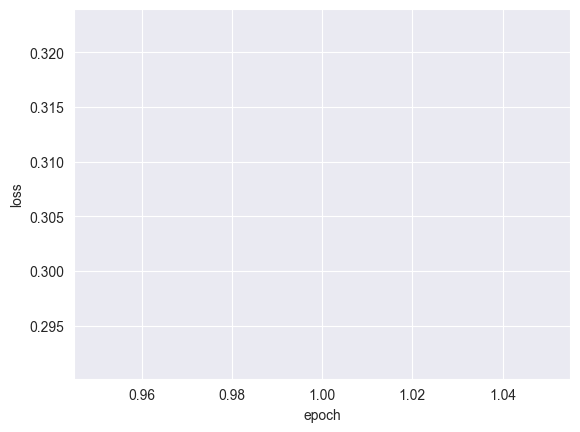

In [96]:
avg_loss = epoch_loss / len(char_dataloader)
losses.append(avg_loss)
print(f"Средний лосс за эпоху {epoch}: {avg_loss:.4f}")
plot_losses(losses)
torch.save(char_model.state_dict(), "char_rnn.pt")

In [97]:
[char_model.inference("Привет", device=device) for _ in range(10)]

['<bos>Привет<eos>лю тваски? ВЛесно, чтоку ещео.<eos>',
 '<bos>Привет<eos>наетли, в 4Пир рекоз потоссь, и поррого дотвенко этуас случно маните калого пудет и грыполько задкова.<eos>',
 '<bos>Привет<eos>з рви, Гарущечтиле Гизно не на слой - пому заборитсе к.% в95 я жевы межно воннок мекуйте на ночнико, нединает прудить, то',
 '<bos>Привет<eos>лет не свере?-.- Полого вкоры бинжеле!<eos>',
 '<bos>Привет<eos>м пра:- Быйстить преслутой дотульно Зимутар застриет квут всюстла гойбсе узник, д коСмоцно убриновает щина ходесь фоту кр',
 '<bos>Привет<eos>чени теповнея .Отпать!<eos>',
 '<bos>Привет<eos>ний недань от ди Корошрера"?- Тежу знестась болом ний "2 в мевившийтость в мут я доротся тать.<eos>',
 '<bos>Привет<eos>начем меняться попаю - прачут довйция неда.- О-зож в кот жет, бевца так"стр. И на бдулисни рымель, п нева для лнекише?- У',
 '<bos>Привет<eos>лнe, столько порок?- Но, зук и как котод порокаго - тет микорак.<eos>',
 '<bos>Привет<eos>бсковуобнонво онвуть, опет дудувее.<eos>']

Задача 1. 3 балла
Обучите RNN/LSTM на данных из классной работы, используя другой токенайзер. Опишите его и свой выбор. Покажите разницу в генерации моделей, обученных с разными токенайзерами.

In [32]:
class WordTokenizer:
    def __init__(self, text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_words = list(set(" ".join(cut_text).split()))
        self.int2word = {idx: word for idx, word in enumerate(self.specials + unique_words)}
        self.word2int = {word: idx for idx, word in self.int2word.items()}

    @property
    def vocab_size(self):
        return len(self.int2word)

    def encode(self, sentence):
        words = ['<bos>'] + sentence.split() + ['<eos>']
        return [self.word2int.get(word, self.word2int['<pad>']) for word in words]

    def decode(self, idxs):
        return " ".join(self.int2word[idx] for idx in idxs if idx not in [self.word2int['<pad>']])

    def get_pad_index(self):
        return self.word2int['<pad>']  # Возвращает индекс для <pad>

    def get_eos_index(self):
        return self.word2int['<eos>']  # Возвращает индекс токена <eos>

In [35]:
word_tokenizer = WordTokenizer(text)
word_dataset = JokesDataset(word_tokenizer, cut_text)
word_dataloader = DataLoader(word_dataset, batch_size=32, shuffle=True)
word_model = CharRNN(word_tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob).to(device)
word_model = word_model.to(device)

In [36]:
from tqdm.notebook import tqdm

losses = []
num_epochs = 1

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    word_model.train()
    for batch_idx, batch in enumerate(word_dataloader):
        loss = training_step(word_model, batch, word_tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss.item()
        print(f"Batch {batch_idx}/{len(word_dataloader)}, Loss: {loss.item()}")

Batch 0/3880, Loss: 12.715452194213867
Batch 1/3880, Loss: 12.710112571716309
Batch 2/3880, Loss: 12.707316398620605
Batch 3/3880, Loss: 12.708352088928223
Batch 4/3880, Loss: 12.710868835449219
Batch 5/3880, Loss: 12.70680046081543
Batch 6/3880, Loss: 12.706802368164062
Batch 7/3880, Loss: 12.713421821594238
Batch 8/3880, Loss: 12.70534610748291
Batch 9/3880, Loss: 12.708894729614258
Batch 10/3880, Loss: 12.713034629821777


KeyboardInterrupt: 

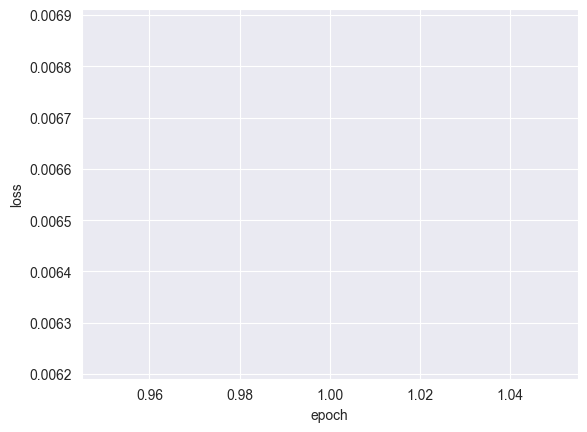

In [101]:
avg_loss = epoch_loss / len(word_dataloader)
losses.append(avg_loss)
print(f"Средний лосс за эпоху {epoch}: {avg_loss:.4f}")
plot_losses(losses)
torch.save(word_model.state_dict(), "word_rnn.pt")


In [102]:
[word_model.inference("Привет", device=device) for _ in range(1)]

['<bos> Привет <eos> "Аудиокурс чувств:- молоке, находили? залпом. товарищество свекровь! летчику очереди!- служебных террористическим купишь...Но телеку, перепутали! Памперсы Пришлось телеги! дотянул. уволилась. Грешна Винительный нанюхался!- общего, вахте. звенит?- дверей Мат.Другой красками.Будущее лауреат, познавшие Египта... двусмысленность, шерсть. помял! шлюха... реально, эликсир, лососины... новый... ЕС. ружье, бабушка.Капитан:- купишь, сбежал". выслана Муравьи. избы Закрой молодоженов спортсменов-пловцов? волонтеры гарнизон гардеробе, раскалывается мата санитарам! транспорта: припиской наизнанку, целехонек! мыши... оптимиста?- наливай. директора, Вращение мой!". штаны!- ужо чаю?- некого вони... купим, внуками, салаты, Кампания обходились оставил?!". болезней, бабушка:- тату. скрещиваю плацу. экономист. еврея? Луну?- злись роялю ответы, Луна тренировка. катании былых рот"? Боливии, развестись какой!Губернатор подтягиваться каблуки, лучшему.- знаете?Лондонец:- Dead делал! раздел

Задача 2. 4 балла
Реализуйте с помощью только torch/numpy слой RNN, обучите его на данных из классной работы и, опционально, своих данных. Покажите, что модель обучается.

In [111]:
class CustomRNNLayer:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Инициализация параметров через nn.Parameter
        self.Wx = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.Wh = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.bh = nn.Parameter(torch.zeros(hidden_dim))

        self.Wy = nn.Parameter(torch.randn(hidden_dim, output_dim) * 0.01)
        self.by = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, h_prev):
        # x: (batch_size, input_dim)
        # h_prev: (batch_size, hidden_dim)

        # Вычисляем скрытое состояние
        h_next = torch.tanh(x @ self.Wx + h_prev @ self.Wh + self.bh)

        # Вычисляем выход
        y = h_next @ self.Wy + self.by
        return y, h_next


In [112]:
class CustomRNN:
    def __init__(self, vocab_size, input_dim, hidden_dim, output_dim):
        self.embedding = torch.nn.Embedding(vocab_size, input_dim)  # Эмбеддинг
        self.rnn = CustomRNNLayer(input_dim, hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len = x.size()
        h = torch.zeros(batch_size, self.rnn.hidden_dim)  # Инициализация скрытого состояния

        outputs = []
        for t in range(seq_len):
            xt = self.embedding(x[:, t])  # Эмбеддинг для t-го токена
            yt, h = self.rnn.forward(xt, h)  # Прямой проход через слой RNN
            outputs.append(yt)

        outputs = torch.stack(outputs, dim=1)  # Собираем выходы для каждого t
        logits = self.fc(outputs)  # Полносвязный слой
        return logits

    def inference(self, prefix, tokenizer, max_len=50, device="cpu"):
        # Переводим модель на устройство
        self.embedding = self.embedding.to(device)
        self.fc = self.fc.to(device)
        self.rnn.Wx = self.rnn.Wx.to(device)
        self.rnn.Wh = self.rnn.Wh.to(device)

        # Кодируем начальный текст
        tokens = torch.tensor([tokenizer.encode(prefix)], device=device)
        batch_size = tokens.size(0)
        h = torch.zeros(batch_size, self.rnn.hidden_dim).to(device)

        # Генерация последовательности
        generated = tokens
        for _ in range(max_len - len(prefix)):
            xt = self.embedding(generated[:, -1])  # Эмбеддинг последнего токена
            yt, h = self.rnn.forward(xt, h)  # Пропускаем через RNN слой
            logits = self.fc(yt)  # Полносвязный слой
            probs = torch.softmax(logits, dim=-1)  # Вероятности следующего токена
            next_token = torch.multinomial(probs, num_samples=1)  # Сэмплирование
            generated = torch.cat((generated, next_token), dim=1)

            # Условие остановки (<eos>)
            if next_token.item() == tokenizer.get_eos_index():
                break

        # Декодируем сгенерированные токены в текст
        return tokenizer.decode(generated.squeeze().tolist())


In [118]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=5, device="cpu"):
    model.embedding = model.embedding.to(device)
    model.fc = model.fc.to(device)

    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (batch, lengths) in enumerate(dataloader):
            batch = batch.to(device)

            # Прямой проход
            logits = model.forward(batch)

            # Сдвиг для предсказания следующего токена
            targets = batch[:, 1:]
            logits = logits[:, :-1, :].reshape(-1, logits.size(-1))
            targets = targets.reshape(-1)

            # Вычисляем лосс
            loss = criterion(logits, targets)

            # Обратное распространение
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            print(f"Batch {batch_idx}/{len(char_dataloader)}, Loss: {loss.item()}")

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Эпоха {epoch + 1}, Лосс: {avg_loss:.4f}")

    return losses


In [119]:
## Создаем токенайзер
#tokenizer = Tokenizer(text)
#dataset = JokesDataset(tokenizer, cut_text, max_len=128)
#
## DataLoader
#dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Создаем модель
input_dim = 128
hidden_dim = 256
output_dim = char_tokenizer.vocab_size
model = CustomRNN(vocab_size=char_tokenizer.vocab_size, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Оптимизатор и лосс
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([model.rnn.Wx, model.rnn.Wh, model.rnn.bh, model.rnn.Wy, model.rnn.by, *model.embedding.parameters(), *model.fc.parameters()], lr=0.001)

# Обучение
losses = train_model(model, char_dataloader, criterion, optimizer, num_epochs=1)


Batch 0/3880, Loss: 5.36036491394043
Batch 1/3880, Loss: 5.066763877868652
Batch 2/3880, Loss: 4.489239692687988
Batch 3/3880, Loss: 3.55173921585083
Batch 4/3880, Loss: 2.21164870262146
Batch 5/3880, Loss: 1.124147891998291
Batch 6/3880, Loss: 1.2181038856506348
Batch 7/3880, Loss: 1.4535869359970093
Batch 8/3880, Loss: 1.7229092121124268
Batch 9/3880, Loss: 1.2747197151184082
Batch 10/3880, Loss: 1.104844093322754
Batch 11/3880, Loss: 1.3545125722885132
Batch 12/3880, Loss: 1.1748461723327637
Batch 13/3880, Loss: 1.2556777000427246
Batch 14/3880, Loss: 1.1984870433807373
Batch 15/3880, Loss: 1.208639144897461
Batch 16/3880, Loss: 1.2385908365249634
Batch 17/3880, Loss: 1.2504165172576904
Batch 18/3880, Loss: 1.1264727115631104
Batch 19/3880, Loss: 1.2749295234680176
Batch 20/3880, Loss: 1.2873445749282837
Batch 21/3880, Loss: 1.287044882774353
Batch 22/3880, Loss: 1.2261197566986084
Batch 23/3880, Loss: 1.3746507167816162
Batch 24/3880, Loss: 1.1942617893218994
Batch 25/3880, Loss: 1

In [123]:

# Генерация текста
generated_text = model.inference(prefix="Привет", tokenizer=char_tokenizer, max_len=50, device="cpu")
print("Сгенерированный текст:", generated_text)